In [33]:
import torch
from torch.nn import functional as F
import numpy as np

import pickle
from os import path
import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, kendalltau

import time
from IPython.display import clear_output
from copy import deepcopy

from collections import defaultdict, OrderedDict

from matplotlib import pyplot as plt

In [2]:
with open('players.pkl', 'rb') as fp:
    players = pickle.load(fp)
with open('results.pkl', 'rb') as fp:
    results = pickle.load(fp)
with open('tournaments.pkl', 'rb') as fp:
    tournaments = pickle.load(fp)

In [3]:
tournaments = [tournament for tournament in tournaments.values() if int(tournament['dateStart'][:4]) >= 2019]
tournaments.sort(key = lambda x: datetime.datetime.strptime(x['dateStart'][:10], '%Y-%m-%d'))

Некоторые турниры проходят в несколько раундов, а потому у разных команд разные длины "масок". Такие турниры будет разбивать на несколько "независимых" турниров с разными составами команд, но фиксированным количеством вопросов в каждом турнире.

In [4]:
def split_result(result):
    if len(result) == 0:
        return []
    
    mask_lens = [len(x['mask']) for x in result]
    if min(mask_lens) == max(mask_lens):
        return [result]
    
    min_len = min(mask_lens)
    
    new_result = []
    for team in result:
        if len(team['mask']) > min_len:
            new_team = deepcopy(team)
            new_team['mask'] = team['mask'][min_len:]
            team['mask'] = team['mask'][:min_len]
            new_result.append(new_team)
            
    return [result] + split_result(new_result)

In [27]:
results_train = []
results_test = []
results_train_ids = []

for tmnt in tournaments:
    result = results[tmnt['id']]
    
    if tmnt['dateStart'][:4] == '2020':
        results_test.append(result)
        continue
        
    result = [{'mask': team.get('mask'),
               'teamMembers': [member['player']['id'] for member in team['teamMembers']]}\
                 for team in result]
        
    result = list(filter(lambda x: (x.get('mask') is not None) and (len(x['teamMembers']) > 0), result))
    for team in result:
        team['mask'] = [1 if char=='1' else 0 for char in team['mask']]
    
    split_results = split_result(result)
    split_results = list(filter(lambda x: len(x) > 1, split_results))
    
    results_train += split_results
    results_train_ids += [tmnt['id']]*len(split_results)

In [6]:
players_in_train = set()
for res in results_train:
    for team in res:
        for member in team['teamMembers']:
            players_in_train.add(member)
players_in_train = {key: value for key, value in players.items() if key in players_in_train}

Скоры игроков будут хранится в векторе, и потребуется словарь для перевода id в индекс и обратно.

In [7]:
player_num_to_id = list(players_in_train.keys())
player_id_to_num = {id_: num for num, id_ in enumerate(player_num_to_id)}

Для бейзлайна считаем, что ответ команды == ответ игрока.

In [8]:
def expect_answers_naive(result):
    answers = []
    for team in result:
        for member in team['teamMembers']:
            answers.append(team['mask'])
            
    return answers

In [9]:
def log_loss(player_scores, question_scores, answers):
    with torch.no_grad():
        a = player_scores[:,None] - question_scores[None,:]
        a = answers*F.softplus(-a) + (1 - answers)*F.softplus(a)
    return a.sum()

def log_grad(player_scores, question_scores, answers):
    with torch.no_grad():
        a = player_scores[:,None] - question_scores[None,:]
        a = torch.sigmoid(a) - answers
        player_grads = a.sum(dim = 1)
        question_grads = - a.sum(dim = 0)
    return player_grads, question_grads

def full_loss(player_scores, data):
    loss = 0.
    for dt in data:
        loss += log_loss(player_scores[dt['player_nums']], dt['question_scores'], dt['answers'])\
            /(dt['answers'].shape[0]*dt['answers'].shape[1])
        
    return loss/len(data)

def full_grad(player_scores, data):
    player_scores_grad = torch.zeros_like(player_scores)
    player_question_pairs = 0
    for dt in data:
        n_pairs = dt['answers'].shape[0]*dt['answers'].shape[1] 
        player_grads, question_grads =\
            log_grad(player_scores[dt['player_nums']], dt['question_scores'], dt['answers'])
        player_grads /= n_pairs*len(data)
        question_grads /= n_pairs*len(data)
        dt['question_scores'].grad = question_grads
        player_scores_grad[dt['player_nums']] += player_grads
        
    return player_scores_grad

In [73]:
player_scores = torch.nn.Parameter(torch.randn(len(player_id_to_num)).float())
data_train = []
for result in results_train:
    answers = torch.FloatTensor(expect_answers_naive(result))
    question_scores = torch.nn.Parameter(torch.randn(answers.shape[1]).float())
    player_nums = []
    for team in result:
        player_nums += [player_id_to_num[p_id] for p_id in team['teamMembers']]
    player_nums = torch.tensor(player_nums)
    data_train.append({
        'answers': answers,
        'question_scores': question_scores,
        'player_nums': player_nums,
    })

In [74]:
params = [player_scores] + [dt['question_scores'] for dt in data_train]
opt = torch.optim.Adam(params, lr=1e-1)

Оптимизируем лосс:

In [75]:
initial_grad_norm = None
max_iter = 100
eps = 1e-3
    
for _ in range(max_iter):
    opt.zero_grad()
    
    player_scores.grad = full_grad(player_scores, data_train)
    
    grad_norm = torch.sqrt(sum([(p.grad**2).sum() for p in params]))
    if initial_grad_norm is None:
        initial_grad_norm = grad_norm
    
    opt.step()
    if grad_norm/initial_grad_norm < eps:
        break

In [76]:
av_question_scores = np.array([dt['question_scores'].detach().numpy().mean() for dt in data_train])
av_player_scores = np.array([player_scores[dt['player_nums']].detach().numpy().mean() for dt in data_train])

In [77]:
player_scores = player_scores.detach().numpy()

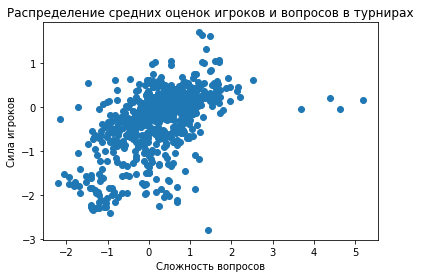

In [78]:
plt.scatter(av_question_scores, av_player_scores)
plt.title('Распределение средних оценок игроков и вопросов в турнирах')
plt.xlabel('Сложность вопросов')
plt.ylabel('Сила игроков')
plt.show()

Можно увидеть, что средний уровень игроков в турнире неплохо предсказывает среднюю сложность вопросов в этом турнире. Это можно использовать для предсказания исходов турниров на тестовом множестве.

Будем считать, что команда отвечает на вопрос правильно, если хотя бы один игрок в команде отвечает правильно. В таком случае чем больше число ($s_i$ --- скоры отдельных игроков, $d$ --- сложность вопроса)
\begin{equation}
    r = \sum\limits_{i=1}^{m}\log \left(1 + \exp(s_i - d)\right),
\end{equation}
тем лучше команда выступит. В пределе $d \rightarrow -\infty$ сравнение чисел $r$ переходит в сравнение сумм скоров игроков, в пределе $d \rightarrow +\infty$ --- в сравнение сумм экспонент скоров игроков. Что в принципе логично: простые вопросы можно задавить "массой", а вот на сложных вклад самого "умного" игрока возрастает.

Будем предсказывать сложности вопросов на турнире при помощи линейной регрессии.

In [79]:
lin_reg = LinearRegression()
lin_reg.fit(av_player_scores[:,None], av_question_scores)

def predict_difficulty(av_player_score):
    return lin_reg.coef_*av_player_score + lin_reg.intercept_

In [80]:
av_player_score = player_scores.mean()

In [81]:
def compute_metric(player_scores, results_test, corr_metric, scores_to_rank_func=lambda x: [-sum(x_) for x_ in x]):
    corrs = []
    for result in results_test:
        if len(result) == 0:
            continue
        
        try:
            true_ranks = [team['position'] for team in result]
        except:
            true_ranks = range(len(result))
            
        if min(true_ranks) == max(true_ranks):
            continue

        scores = []
        av_player_score = player_scores.mean()
        for team in result:
            team_scores = []
            for member in team['teamMembers']:
                player_id = member['player']['id']
                if player_id in player_id_to_num.keys():
                    team_scores.append(player_scores[player_id_to_num[player_id]])
                else:
                    team_scores.append(av_player_score)
            scores.append(team_scores)
        
        pred_ranks = scores_to_rank_func(scores)
        corrs.append(corr_metric(true_ranks, pred_ranks).correlation)
        
    return sum(corrs)/len(corrs)

In [82]:
def scores_to_ranks(scores):
    av_p_score = []
    for s in scores:
        av_p_score += s
    av_p_score = sum(av_p_score)/len(av_p_score)
    
    diff = predict_difficulty(av_p_score)
    
    ranks = []
    for s in scores:
        s = torch.tensor(s)
        ranks.append(-F.softplus(s - diff).sum().item())
        
    return ranks

Вычислим разные метрики, при этом ранжируя команды как "наивным" способом (используя суммы скоров игроков), так и при помощи описанного выше метода.

In [83]:
compute_metric(player_scores, results_test, spearmanr)

0.719097670084765

In [84]:
compute_metric(player_scores, results_test, spearmanr, scores_to_ranks)

0.7597160809027229

In [85]:
compute_metric(player_scores, results_test, kendalltau)

0.5631680538528733

In [86]:
compute_metric(player_scores, results_test, kendalltau, scores_to_ranks)

0.6042253659319489

-------------------------------------------------------------

В EM алгоритме в качестве скрытых переменных будем вводить ответы каждого игрока в отдельности. M-шаг алгоритма остаётся тем же, что и в бейзлайне. На E-шаге нужно оценить вероятность того, что игрок дал правильный ответ на вопрос при условии скора игрока $s$, сложности вопроса $d$ и того, какой ответ в целом дала команда.

Как говорилось ранее, если команда дала неверный ответ, то игрок точно дал неверный ответ, т.е. $\mathbb{E}z(s,d,y=0) = 0$. Если же команда дала правильный ответ,
\begin{equation}
    \mathbb{E}z_i(y=1) = \mathbb{E} p(z_i = 1, z_{j\neq i}|\sum\limits_{k=0}^{m} z_k > 0)
        = \frac{p(z_i = 1)}{1 - p(\sum z_k = 0)}
\end{equation}

In [12]:
def update_answer_expectations(player_scores, data, results):
    with torch.no_grad():
        for result, dt in zip(results, data):
            team_sizes = [len(team['teamMembers']) for team in result]
            q_s = dt['question_scores']
            new_answers = []
            for team in result:
                mask = torch.tensor(team['mask'])
                player_nums = torch.tensor([player_id_to_num[p_id] for p_id in team['teamMembers']])
                p_s = player_scores[player_nums]
                expected_answers = torch.sigmoid(p_s[:,None] - q_s[None,:])
                expected_answers = expected_answers/(1 - (1 - expected_answers).prod(dim=0))
                expected_answers = expected_answers*mask[None,:]
                
                new_answers.append(expected_answers)
                
            new_answers = torch.cat(new_answers, dim=0)
            dt['answers'] = new_answers

In [16]:
player_scores = torch.nn.Parameter(torch.randn(len(player_id_to_num)).float())
data_train = []
for result in results_train:
    answers = torch.FloatTensor(expect_answers_naive(result))
    question_scores = torch.nn.Parameter(torch.randn(answers.shape[1]).float())
    player_nums = []
    for team in result:
        player_nums += [player_id_to_num[p_id] for p_id in team['teamMembers']]
    player_nums = torch.tensor(player_nums)
    data_train.append({
        'answers': answers,
        'question_scores': question_scores,
        'player_nums': player_nums,
    })

In [17]:
params = [player_scores] + [dt['question_scores'] for dt in data_train]
opt = torch.optim.Adam(params, lr=1e-1)

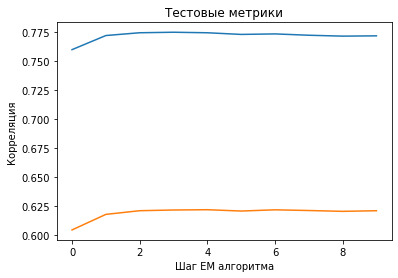

In [18]:
initial_grad_norm = None
max_em_iter = 10
max_iter = 100
eps = 1e-3
    
    
history = defaultdict(list)

for _ in range(max_em_iter):

    for _ in range(max_iter):
        opt.zero_grad()

        player_scores.grad = full_grad(player_scores, data_train)

        grad_norm = torch.sqrt(sum([(p.grad**2).sum() for p in params]))
        if initial_grad_norm is None:
            initial_grad_norm = grad_norm

        opt.step()
        if grad_norm/initial_grad_norm < eps:
            break
            
    history['player_scores'].append(player_scores.detach().numpy())
    history['question_scores'].append([dt['question_scores'].detach().numpy() for dt in data_train])
        
    update_answer_expectations(player_scores, data_train, results_train)
    
    av_question_scores = np.array([dt['question_scores'].detach().numpy().mean() for dt in data_train])
    av_player_scores = np.array([player_scores[dt['player_nums']].detach().numpy().mean() for dt in data_train])
    
    history['av_question_scores'].append(av_question_scores)
    history['av_player_scores'].append(av_player_scores)
    
    lin_reg = LinearRegression()
    lin_reg.fit(av_player_scores[:,None], av_question_scores)

    def predict_difficulty(av_player_score):
        return lin_reg.coef_*av_player_score + lin_reg.intercept_
    
    history['diff_pred_coef_'].append(lin_reg.coef_)
    history['diff_pred_intercept_'].append(lin_reg.intercept_)
    
    spearman_metric = compute_metric(history['player_scores'][-1], results_test, spearmanr, scores_to_ranks)
    kendall_metric = compute_metric(history['player_scores'][-1], results_test, kendalltau, scores_to_ranks)
    
    history['spearman'].append(spearman_metric)
    history['kendall'].append(kendall_metric)
    
    em_steps_done = len(history['spearman'])
    
    clear_output(True)
    plt.title("Тестовые метрики")
    plt.xlabel("Шаг ЕМ алгоритма")
    plt.ylabel("Корреляция")
    plt.plot(range(em_steps_done), history['spearman'], label='Спирмен')
    plt.plot(range(em_steps_done), history['kendall'], label='Кендалл')
    plt.show()

Целевые метрики и правда немного растут на первых итерациях.

In [19]:
best_iteration = 3
model_output = {k:v[best_iteration] for k, v in history.items()}

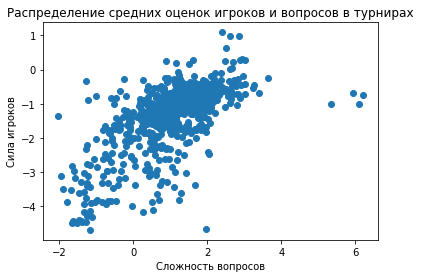

In [23]:
plt.scatter(model_output['av_question_scores'], model_output['av_player_scores'])
plt.title('Распределение средних оценок игроков и вопросов в турнирах')
plt.xlabel('Сложность вопросов')
plt.ylabel('Сила игроков')
plt.show()

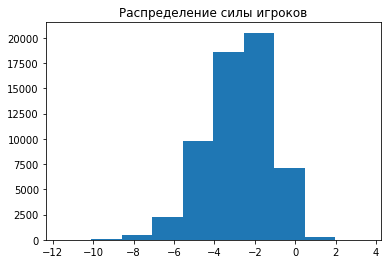

In [24]:
plt.title("Распределение силы игроков")
plt.hist(model_output['player_scores'])
plt.show()

In [46]:
tournament_diffs = dict()
for tournament_id, question_scores in zip(results_train_ids, model_output['question_scores']):
    if tournament_id not in tournament_diffs.keys():
        tournament_diffs[tournament_id] = [0., 0]
    tournament_diffs[tournament_id][0] += question_scores.sum()
    tournament_diffs[tournament_id][1] += len(question_scores)
tournament_diffs = {k: v[0]/v[1] for k, v in tournament_diffs.items()}
tournament_diffs = list(sorted(tournament_diffs.items(), key=lambda item: item[1], reverse=True))

In [50]:
with open('tournaments.pkl', 'rb') as fp:
    tournaments_dict = pickle.load(fp)

In [55]:
for k,v in tournament_diffs[:10]:
    print(f"diff = {v:.3f} " + tournaments_dict[k]['name'])

diff = 6.675 Чемпионат Санкт-Петербурга. Первая лига
diff = 3.332 Угрюмый Ёрш
diff = 3.286 Синхрон высшей лиги Москвы
diff = 3.116 Воображаемый музей
diff = 3.051 Зеркало мемориала памяти Михаила Басса
diff = 3.029 Первенство правого полушария
diff = 2.991 Чемпионат Мира. Этап 2 Группа С
diff = 2.866 Чемпионат Мира. Этап 2. Группа В
diff = 2.787 Мемориал памяти Михаила Басса
diff = 2.766 Знание – Сила VI


In [56]:
for k,v in tournament_diffs[-10:]:
    print(f"diff = {v:.3f} " + tournaments_dict[k]['name'])

diff = -1.137 Школьная лига
diff = -1.173 (а)Синхрон-lite. Лига старта. Эпизод IX
diff = -1.189 Школьная лига. II тур.
diff = -1.351 Школьный Синхрон-lite. Выпуск 2.5
diff = -1.382 Школьная лига. I тур.
diff = -1.393 Школьная лига. III тур.
diff = -1.407 (а)Синхрон-lite. Лига старта. Эпизод V
diff = -1.409 Студенческий чемпионат Калининградской области
diff = -1.414 Асинхрон по South Park
diff = -1.724 Синхрон Лиги Разума
